In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import rasterio as rs
import cartopy
import os
import pyproj
from rasterio import mask
import shapely
import pandas as pd
import seaborn as sns

In [2]:
## create a class to allow for easy generation of maps, files, and dataframes
class map_generator:
    def __init__(self, list_files):
        self.file_names=list_files
     
    ## finds the max windspeed of a given year. returns a nc file
    def agg_max(self,year):
        map_files=[file for file in self.file_names if file[-9:-5]==year]
        for i,file in enumerate(map_files):
            fp=xr.open_dataset(file)
            if i==0:
                max_mag=fp.max(dim=['Time'])
            else:
                max_mag_month=fp.max(dim=['Time'])
                max_mag=xr.concat([max_mag,max_mag_month],dim='Time')
        max_value=max_mag.max(dim=['Time'])['mag']
        return max_value
    
    ## finds the mean wind speed of a given year. returns an nc file
    def agg_mean(self,year):
        map_files=[file for file in self.file_names if file[-9:-5]==year]
        for i,file in enumerate(map_files):
            fp=xr.open_dataset(file)
            if i==0:
                mean_mag=fp.mean(dim=['Time'])
            else:
                mean_mag_month=fp.mean(dim=['Time'])
                mean_mag=xr.concat([mean_mag,mean_mag_month],dim='Time')
        mean_value=mean_mag.max(dim=['Time'])['mag']
        return mean_value
    
    ## converts nc to tif file. nc file must be only one time step
    def dem_to_tif(self,dem,output_file='/shared_space/ACV/tif_files/placeholder.tif'):
        nc_file='/shared_space/ACV/inter_files/nc_to_translate.nc'
        inter_file='/shared_space/ACV/inter_files/inter_file.tif'
        output_file='/shared_space/ACV/inter_files/output_file.tif'
        if os.path.exists(nc_file):
            os.remove(nc_file)
        if os.path.exists(inter_file):
            os.remove(inter_file)
        dem.to_netcdf(nc_file)
        string_1="gdal_translate -a_srs '+proj=lcc +a=6370000 +b=6370000 +lon_0=-97.899994 +lat_0=39.100006 +lat_1=30.0 +lat_2=50.0 +datum=WGS84 +units=m +no_defs' -a_ullr 1144000.0 8000.0 2084000.0 -528000.0 %s %s"
        string_2="gdalwarp -overwrite -r average -s_srs '+proj=lcc +a=6370000 +b=6370000 +lon_0=-97.899994 +lat_0=39.100006 +lat_1=30.0 +lat_2=50.0 \
        +datum=WGS84 +units=m +no_defs' -t_srs EPSG:4326 %s %s"
        os.system(string_1%(nc_file,inter_file))
        os.system(string_2%(inter_file,output_file))
        return rs.open(output_file)

    def plotter(self, year, max_mean, county=True):
        if max_mean == 'max':
            agg_dem = self.agg_max(year)
            print_type = 'Max'
        elif max_mean == 'mean':
            agg_dem = self.agg_mean(year)
            print_type = 'Mean'
        else:
            print('cannot plot max_mean')

        plot_fp = self.dem_to_tif(agg_dem)
        dem = plot_fp.read(1)
        extent = [plot_fp.bounds[0], plot_fp.bounds[2], plot_fp.bounds[1], plot_fp.bounds[3]]

        county_fp = gpd.read_file('/shared_space/ACV/county_shp/NCDOT_County_Boundaries.shp')
        county_fp = county_fp.to_crs('EPSG:4326')
        county_fp['geometry'] = county_fp['geometry'].apply(lambda geometry: shapely.ops.transform(lambda x, y: (y, x), geometry))

        fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
        c = ax.imshow(dem, transform=ccrs.PlateCarree(), cmap='viridis', origin='upper', extent=extent)
        ax.set_title(f'{year} {print_type} Wind Speed')
        if county == True:
            ax.add_geometries(county_fp.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
        plt.show()

        # Intersect shapefile with the tif data
        output_arrays = county_fp.apply(lambda x: mask.mask(plot_fp, [x['geometry']])[0][0, :, :], axis=1)
        output_arrays = output_arrays.apply(lambda arr: np.nan_to_num(arr, nan=-99999))

        speeds = {}
        for i, county in enumerate(output_arrays):
            speeds[county_fp['CountyName'][i]] = plot_fp.read(1)[output_arrays[i] != -99999]

        results_df = pd.DataFrame([])
        results_df['County'] = list(speeds.keys())
        results_df['mean'] = results_df.apply(lambda x: np.mean(speeds[x['County']]), axis=1)
        results_df['max'] = results_df.apply(lambda x: np.max(speeds[x['County']]), axis=1)

        return results_df

cdf_list=glob.glob('/shared_space/ACV/extracted_raw/mag_dir/*')
all_data=map_generator(cdf_list)

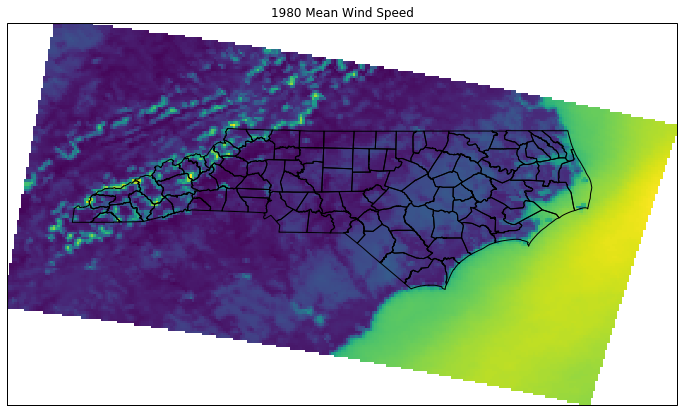

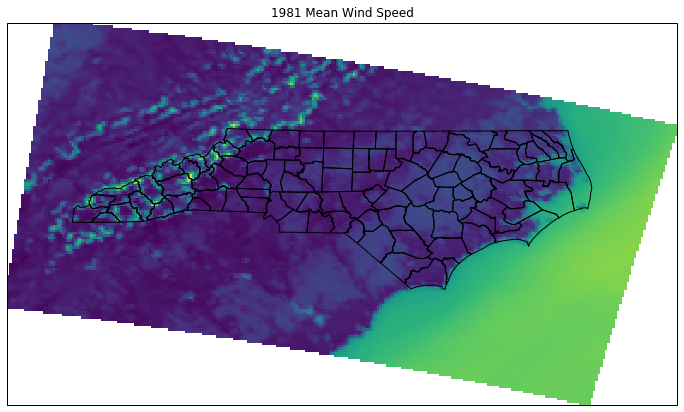

KeyboardInterrupt: 

In [3]:
# List to store yearly mean wind speed for Dare County
dare_county_means = []
years = range(1980, 2016)  # 1980 to 2015

# Iterate over each year
for year in years:
    year_str = str(year)
    try:
        # Generate results for the mean wind speed for the current year
        results_df = all_data.plotter(year=year_str, max_mean='mean', county=True)
        # Filter results for Dare County
        dare_mean = results_df[results_df['County'] == 'Watauga']['mean'].values[0]
        dare_county_means.append(dare_mean)
    except Exception as e:
        print(f"Error processing year {year}: {e}")
        dare_county_means.append(None)

# Create a DataFrame for plotting
dare_df = pd.DataFrame({
    'Year': list(years),
    'Mean Wind Speed': dare_county_means
})

# Drop years with no data
dare_df = dare_df.dropna()

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=dare_df, x='Year', y='Mean Wind Speed', marker='o')
plt.title('Mean Wind Speed in Dare County (1980-2015)')
plt.xlabel('Year')
plt.ylabel('Mean Wind Speed (m/s)')
plt.grid(True)
plt.show()


In [13]:
print(dare_df)

dare_df.to_csv('watauga_mean_speeds_1980_2015.csv', index=False)

    Year  Mean Wind Speed
0   1980         5.392171
1   1981         5.832065
2   1982         5.875263
3   1983         5.437372
4   1984         5.393981
5   1985         6.212462
6   1986         5.541671
7   1987         5.437217
8   1988         5.543035
9   1989         5.293954
10  1990         5.267163
11  1991         5.188236
12  1992         5.421573
13  1993         5.379561
14  1994         5.498292
15  1995         5.375301
16  1996         5.866462
17  1997         5.663700
18  1998         5.012593
19  1999         5.528472
20  2000         5.465067
21  2001         5.512370
22  2002         5.426190
23  2003         5.912547
24  2004         5.821788
25  2005         5.275872
26  2006         5.651574
27  2007         5.813506
28  2008         5.636834
29  2009         5.448063
30  2010         5.773704
31  2011         5.643163
32  2012         5.364842
33  2013         5.651147
34  2014         5.518916
35  2015         5.473650


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of years from 1980 to 2015
years = [str(year) for year in range(1980, 2016)]
mean_speeds = []

# Loop through each year and get the mean wind speed for Durham County
for year in years:
    results_df = all_data.plotter(year, 'mean')
    durham_speed = results_df[results_df['County'] == 'Durham']['mean'].values
    if len(durham_speed) > 0:
        mean_speeds.append(durham_speed[0])
    else:
        mean_speeds.append(None)  # In case Durham County is missing data for any year

# Plotting the line graph
plt.figure(figsize=(10, 6))
sns.lineplot(x=years, y=mean_speeds, marker='o', color='tab:blue')
plt.title('Mean Wind Speed in Durham County (1980-2015)')
plt.xlabel('Year')
plt.ylabel('Mean Wind Speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


UnboundLocalError: local variable 'mean_mag' referenced before assignment

In [16]:
data = {'Year': years, 'Mean_Speed': mean_speeds}
mean_speeds_df = pd.DataFrame(data)

# Display the DataFrame
print(mean_speeds_df)

# Save to CSV if needed
mean_speeds_df.to_csv('dare_mean_speeds_1980_2015.csv', index=False)

    Year  Mean_Speed
0   1980    2.857051
1   1981    3.025684
2   1982    2.910831
3   1983    2.867068
4   1984    2.901891
5   1985    2.757051
6   1986    2.716729
7   1987    2.908365
8   1988    2.970751
9   1989    2.814382
10  1990    2.886998
11  1991    2.699106
12  1992    2.736208
13  1993    3.115202
14  1994    2.895082
15  1995    2.658774
16  1996    3.175241
17  1997    3.012219
18  1998    2.776546
19  1999    3.013174
20  2000    2.955782
21  2001    2.752856
22  2002    2.714554
23  2003    2.705782
24  2004    2.758927
25  2005    3.074741
26  2006    2.591510
27  2007    3.018158
28  2008    2.935902
29  2009    2.876340
30  2010    2.797411
31  2011    3.121128
32  2012    2.776640
33  2013    2.923061
34  2014    2.850465
35  2015    2.817477


In [15]:
mean_speeds

[2.857050895690918,
 3.025683879852295,
 2.9108312129974365,
 2.867068290710449,
 2.901890516281128,
 2.757051467895508,
 2.716728925704956,
 2.90836501121521,
 2.9707508087158203,
 2.8143820762634277,
 2.886997938156128,
 2.6991055011749268,
 2.736208438873291,
 3.115201950073242,
 2.8950822353363037,
 2.6587741374969482,
 3.175241231918335,
 3.012218713760376,
 2.776545524597168,
 3.013174295425415,
 2.955782413482666,
 2.7528560161590576,
 2.7145540714263916,
 2.705781936645508,
 2.7589271068573,
 3.0747413635253906,
 2.5915095806121826,
 3.018158197402954,
 2.935901641845703,
 2.876340389251709,
 2.797410726547241,
 3.1211278438568115,
 2.776639938354492,
 2.9230613708496094,
 2.8504650592803955,
 2.817476987838745]

In [ ]:
years = [str(year) for year in range(1980, 2016)]